In [1]:
import sys
sys.path.insert(0, './src/yelp_prediction')

In [2]:
import polars as pl
import dataframes as df
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [3]:
(df_businesses, df_exact_stars, df_photos_per_business, df_photos) = pl.collect_all(
    (
        df.q_businesses,
        df.q_exact_stars,
        df.q_photos_agg,
        df.q_photos
    )
)

In [4]:
predictions = pl.read_csv("data/predictions.csv")
display(predictions)

epoch,photo_id,prediction
i64,str,f64
1,"""OpOwh2UKK9AzEv1vZzBLdw""",3.120211
1,"""cwOKKSPs7JWTwkNghhwCeQ""",3.52143
1,"""bNkN0ro_9KAVpV6tQw_qpQ""",3.843519
1,"""LFMG-3MG6ZPmKdl4Knohpw""",3.739122
1,"""FkgoVsPwGqCRZWiuYfLMTg""",3.727125
…,…,…
20,"""a5X97Uus-G6xKbEukFB0kQ""",3.80656
20,"""ICbiOHh9PqiueJrBPd6rWw""",3.467321
20,"""I321FJ8CQ2fuA3jmMTibHg""",4.258736


In [5]:
table = (
    df_photos.join(predictions, on="photo_id")
    .join(df_exact_stars, on="business_id")
    .join(df_businesses, on="business_id")
    .join(df_photos_per_business, on="business_id")
    .select(
        pl.col("epoch"),
        pl.col("photo_id"),
        pl.col("business_id"),
        pl.col("photo_count").alias("business_photo_count"),
        pl.col("label"),
        pl.col("review_count").alias("business_review_count"),
        pl.col("prediction"),
        pl.col("exact_stars").alias("actual"),
    )
    .with_columns(
        (pl.col("prediction") - pl.col("actual")).alias("error"),
    )
    .with_columns(
        pl.col("error").abs().alias("abs_error"),
    )
)

display(table)

epoch,photo_id,business_id,business_photo_count,label,business_review_count,prediction,actual,error,abs_error
i64,str,str,u32,str,i64,f64,f64,f64,f64
1,"""OpOwh2UKK9AzEv1vZzBLdw""","""ySSOZ_fz7wMhfjhWKzdR-w""",13,"""food""",520,3.120211,3.943182,-0.822971,0.822971
1,"""cwOKKSPs7JWTwkNghhwCeQ""","""ySSOZ_fz7wMhfjhWKzdR-w""",13,"""drink""",520,3.52143,3.943182,-0.421752,0.421752
1,"""bNkN0ro_9KAVpV6tQw_qpQ""","""ySSOZ_fz7wMhfjhWKzdR-w""",13,"""food""",520,3.843519,3.943182,-0.099662,0.099662
1,"""LFMG-3MG6ZPmKdl4Knohpw""","""ySSOZ_fz7wMhfjhWKzdR-w""",13,"""inside""",520,3.739122,3.943182,-0.20406,0.20406
1,"""FkgoVsPwGqCRZWiuYfLMTg""","""ySSOZ_fz7wMhfjhWKzdR-w""",13,"""inside""",520,3.727125,3.943182,-0.216057,0.216057
…,…,…,…,…,…,…,…,…,…
20,"""a5X97Uus-G6xKbEukFB0kQ""","""onufA0MixmTq5_VR_Zrx8Q""",7,"""food""",77,3.80656,3.823529,-0.01697,0.01697
20,"""ICbiOHh9PqiueJrBPd6rWw""","""onufA0MixmTq5_VR_Zrx8Q""",7,"""food""",77,3.467321,3.823529,-0.356208,0.356208
20,"""I321FJ8CQ2fuA3jmMTibHg""","""onufA0MixmTq5_VR_Zrx8Q""",7,"""food""",77,4.258736,3.823529,0.435206,0.435206


In [6]:
table_by_epoch = (
    table.group_by("epoch")
    .agg(
        pl.col("abs_error").mean().alias("mae"),
        pl.col("error").pow(2).mean().alias("mse"),
    )
    .with_columns(
        pl.col("mse").sqrt().alias("rmse"),
    )
    .sort("epoch")
)

display(table_by_epoch)


epoch,mae,mse,rmse
i64,f64,f64,f64
1,0.379195,0.243152,0.493104
2,0.374366,0.247505,0.497499
3,0.375068,0.242709,0.492655
4,0.369487,0.238094,0.487949
5,0.369156,0.234008,0.483744
…,…,…,…
16,0.369616,0.237388,0.487224
17,0.372122,0.239595,0.489485
18,0.373198,0.240638,0.490549


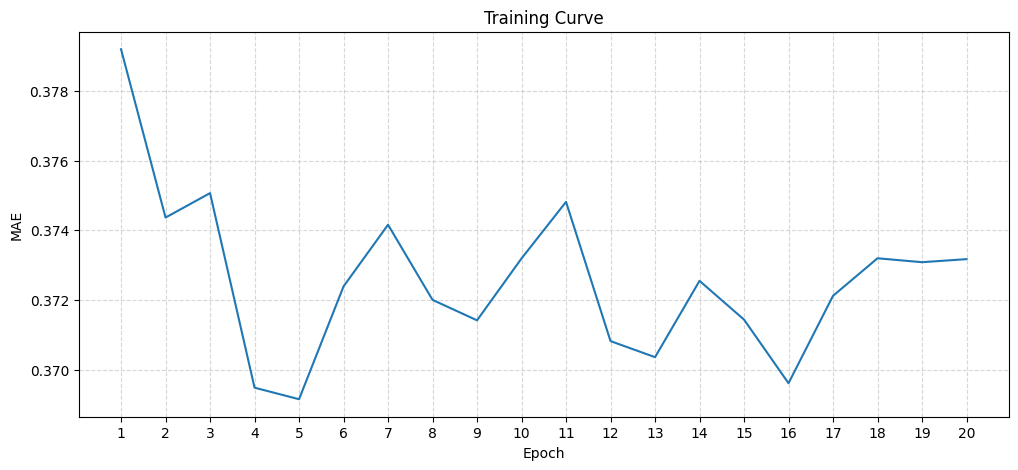

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(
    table_by_epoch["epoch"],
    table_by_epoch["mae"],
)
plt.title("Training Curve")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.xticks(range(1, 21))
plt.grid(True, which="both", ls="--", alpha=0.5)

In [8]:
def _get_best_table_by(col: str):
    best_epoch = table_by_epoch.sort(by=col).slice(0, 1).select("epoch").item()
    best_epoch_table = table.filter(pl.col("epoch") == best_epoch).drop("epoch")
    return best_epoch, best_epoch_table


best_epoch, best_epoch_table = _get_best_table_by("mae")
display(best_epoch_table)

photo_id,business_id,business_photo_count,label,business_review_count,prediction,actual,error,abs_error
str,str,u32,str,i64,f64,f64,f64,f64
"""OpOwh2UKK9AzEv1vZzBLdw""","""ySSOZ_fz7wMhfjhWKzdR-w""",13,"""food""",520,3.360826,3.943182,-0.582356,0.582356
"""cwOKKSPs7JWTwkNghhwCeQ""","""ySSOZ_fz7wMhfjhWKzdR-w""",13,"""drink""",520,3.272753,3.943182,-0.670429,0.670429
"""bNkN0ro_9KAVpV6tQw_qpQ""","""ySSOZ_fz7wMhfjhWKzdR-w""",13,"""food""",520,4.002422,3.943182,0.059241,0.059241
"""LFMG-3MG6ZPmKdl4Knohpw""","""ySSOZ_fz7wMhfjhWKzdR-w""",13,"""inside""",520,3.569686,3.943182,-0.373496,0.373496
"""FkgoVsPwGqCRZWiuYfLMTg""","""ySSOZ_fz7wMhfjhWKzdR-w""",13,"""inside""",520,3.433995,3.943182,-0.509187,0.509187
…,…,…,…,…,…,…,…,…
"""a5X97Uus-G6xKbEukFB0kQ""","""onufA0MixmTq5_VR_Zrx8Q""",7,"""food""",77,3.817891,3.823529,-0.005639,0.005639
"""ICbiOHh9PqiueJrBPd6rWw""","""onufA0MixmTq5_VR_Zrx8Q""",7,"""food""",77,3.392202,3.823529,-0.431328,0.431328
"""I321FJ8CQ2fuA3jmMTibHg""","""onufA0MixmTq5_VR_Zrx8Q""",7,"""food""",77,4.150409,3.823529,0.32688,0.32688


In [9]:
best_epoch_table_grouped = best_epoch_table.group_by("business_id").agg(
    abs_error=pl.col("abs_error").mean(),
    actual=pl.col("actual").first(),
)

print("grouped MAE:", best_epoch_table_grouped["abs_error"].mean())

best_epoch_table_grouped

grouped MAE: 0.4357241354302379


business_id,abs_error,actual
str,f64,f64
"""0mijbNf-7wiKJ9xto1pAyg""",0.100502,4.296407
"""ZQJGYnN9J-1JMLzeDFWocA""",0.431094,3.137255
"""v15BmLCOHx6pDwd9kAgMYA""",1.11623,1.828947
"""0CssPu4DgIImkouHXKTY6Q""",0.128773,3.84106
"""6cthUjghHSevS64rOYjGVw""",1.164133,2.688889
…,…,…
"""Sy4VvCqRsPB0IN8u-0wVtQ""",0.284505,3.822115
"""fWYdugISWgqI2849hcBCTg""",0.659197,2.545455
"""DOfiulOub9hVPBCtiDl9Fw""",0.116149,4.092988


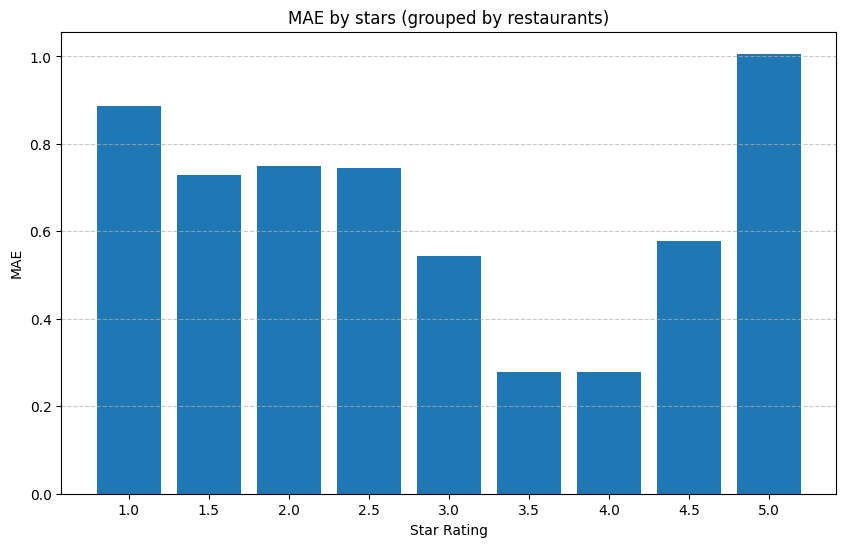

In [10]:
step_size = 0.5
floored_stars_q = (pl.col("actual") / step_size).floor() * step_size
grouped = (
    best_epoch_table_grouped.group_by(floored_stars_q.alias("stars"))
    .agg(
        pl.col("abs_error").mean().alias("mae"),
        pl.col("abs_error").pow(2).mean().alias("mse"),
    )
    .sort("stars")
)

plt.figure(figsize=(10, 6))
plt.bar(
    x=grouped["stars"],
    height=grouped["mae"],
    width=0.4,
)
plt.title("MAE by stars (grouped by restaurants)")
plt.xlabel("Star Rating")
plt.ylabel("MAE")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([x/2+1 for x in range(9)]);

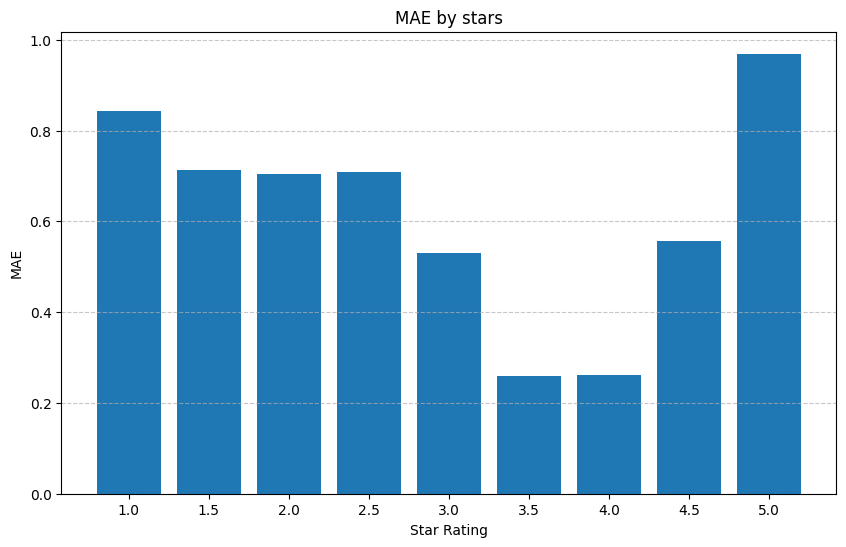

In [11]:
step_size = 0.5
floored_stars_q = (pl.col("actual") / step_size).floor() * step_size
grouped = (
    best_epoch_table.group_by(floored_stars_q.alias("stars"))
    .agg(
        pl.col("abs_error").mean().alias("mae"),
        pl.col("error").pow(2).mean().alias("mse"),
    )
    .sort("stars")
)

plt.figure(figsize=(10, 6))
plt.bar(
    x=grouped["stars"],
    height=grouped["mae"],
    width=0.4,
)
plt.title("MAE by stars")
plt.xlabel("Star Rating")
plt.ylabel("MAE")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([x/2+1 for x in range(9)]);

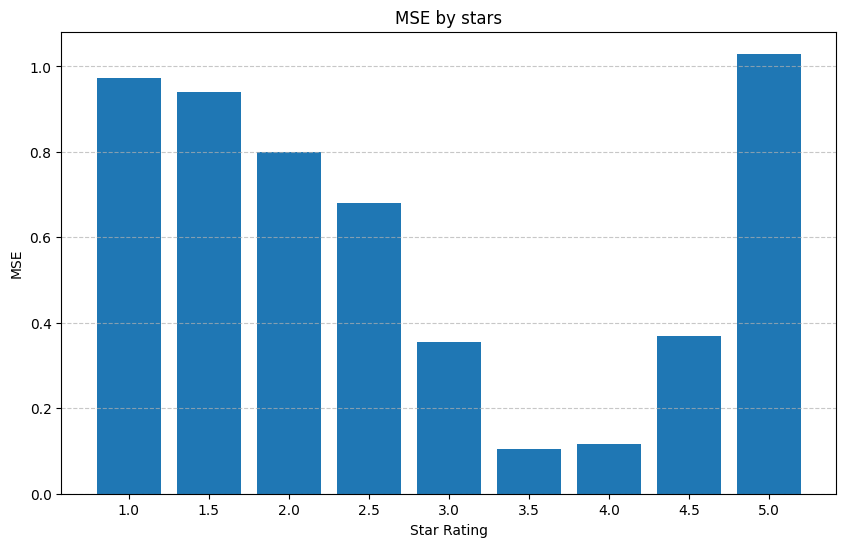

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(
    x=grouped["stars"],
    height=grouped["mse"],
    width=0.4,
)
plt.title("MSE by stars")
plt.xlabel("Star Rating")
plt.ylabel("MSE")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([x/2+1 for x in range(9)]);

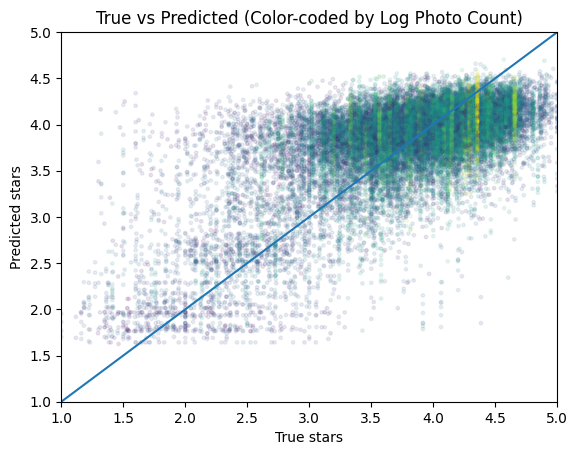

In [13]:
plt.figure()
plt.scatter(
    x=best_epoch_table["actual"],
    y=best_epoch_table["prediction"],
    c=best_epoch_table["business_photo_count"],
    norm=colors.LogNorm(
        vmin=best_epoch_table["business_photo_count"].min(), # type: ignore
        vmax=best_epoch_table["business_photo_count"].max(), # type: ignore
    ),
    cmap='viridis',
    s=6,
    alpha=0.1,
)
plt.plot([1, 5], [1, 5])
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.xlabel("True stars")
plt.ylabel("Predicted stars")
plt.title("True vs Predicted (Color-coded by Log Photo Count)")

None

In [14]:
aggr_by_business = best_epoch_table.group_by("business_id").agg(
    pl.col("abs_error").mean(),
    pl.col("business_photo_count").first(),
    pl.col("business_review_count").first(),
)

aggr_by_business

business_id,abs_error,business_photo_count,business_review_count
str,f64,u32,i64
"""dKLfvJaR-dCk84TCdTMWnA""",0.162931,12,176
"""TSVy1TGUymrtG1uqDXm63A""",0.160569,5,160
"""eSIpWX2r37csb4VXDZ38lw""",0.679638,2,80
"""gZxZpb21YNjCIYg5_yy6xA""",0.919232,8,55
"""4tggaX0XrqYEaJOBFCcD5A""",0.362833,1,119
…,…,…,…
"""uaX77w8_uIhu9EwxpdwOZQ""",0.356239,9,77
"""TJUALKgDgyGaEffzmJ7WoQ""",0.206706,2,46
"""mHRUYrn45b7L2JP1jqER0w""",0.569017,3,58


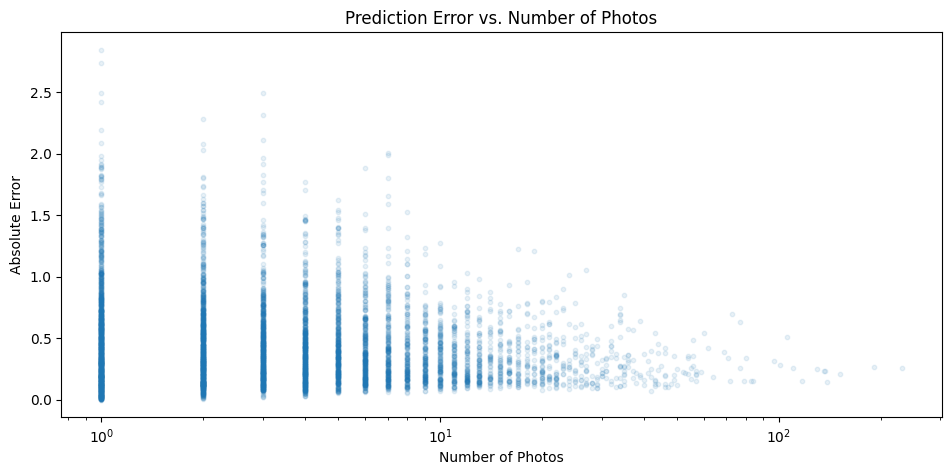

In [15]:
plt.figure(figsize=(25, 5))
plt.subplot(1, 2, 1)
plt.scatter(
    x=aggr_by_business["business_photo_count"],
    y=aggr_by_business["abs_error"],
    alpha=0.1,
    s=10,
)
plt.title("Prediction Error vs. Number of Photos")
plt.xlabel("Number of Photos")
plt.ylabel("Absolute Error")
plt.xscale("log")

None

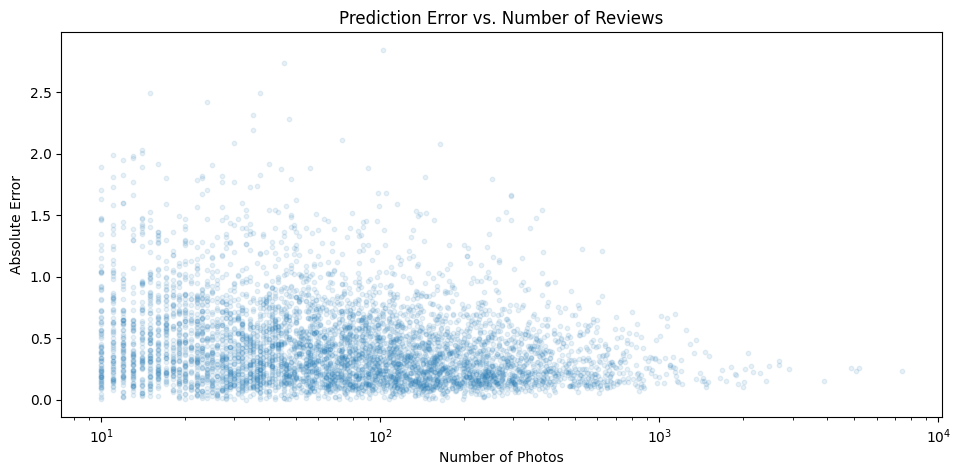

In [16]:
plt.figure(figsize=(25, 5))
plt.subplot(1, 2, 1)
plt.scatter(
    x=aggr_by_business["business_review_count"],
    y=aggr_by_business["abs_error"],
    alpha=0.1,
    s=10,
)
plt.title("Prediction Error vs. Number of Reviews")
plt.xlabel("Number of Photos")
plt.ylabel("Absolute Error")
plt.xscale("log")
None